## 共通処理

In [28]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [20]:
import pymc as pm
import arviz as az

## ch5

### 線形回帰のベイズ推論(複数項目の観測値の関係性を示すパラメータ)

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

(50, 5)


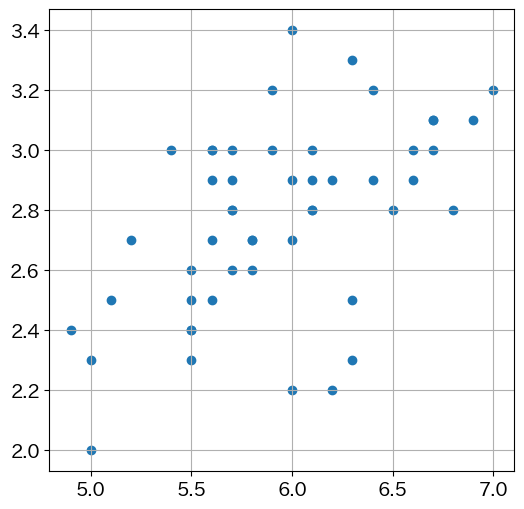

In [21]:
# 分析データの可視化
df = sns.load_dataset("iris")
display(df["species"].value_counts())

df1 = df[df["species"] == "versicolor"]
print(df1.shape)

X = df1["sepal_length"]
Y = df1["sepal_width"]

plt.scatter(X, Y)

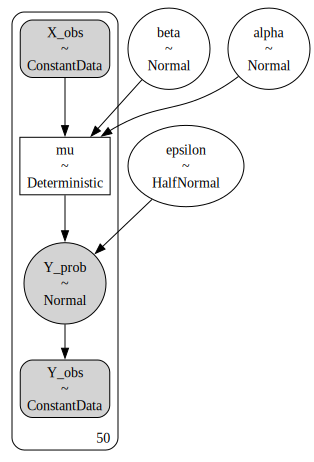

In [22]:
# 確率モデル構造を定義
model = pm.Model()

with model:
    # X, Yの観測値をConstantDataとして定義
    X_obs = pm.ConstantData("X_obs", X)
    Y_obs = pm.ConstantData("Y_obs", Y)

    # alpha, betaを確率変数として定義(1次関数の傾きと切片)
    alpha = pm.Normal("alpha", mu = 0.0, sigma = 10.0)
    beta = pm.Normal("beta", mu = 0.0, sigma = 10.0)

    # 平均値muを確率変数として定義(Yの期待値的な？)
    mu = pm.Deterministic("mu", alpha * X_obs + beta)

    # 誤差の確率変数としてepsilonを定義
    epsilon = pm.HalfNormal("epsilon", sigma = 1.0)

    # 観測値を持つ確率変数としてYを定義
    Y_prob = pm.Normal("Y_prob", mu = mu, sigma = epsilon, observed = Y_obs)

g = pm.model_to_graphviz(model)
display(g)

In [23]:
# サンプリング
with model:
    idata = pm.sample(chains = 2, tune = 1000, draws = 1000, 
                      random_seed = 42
                      )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


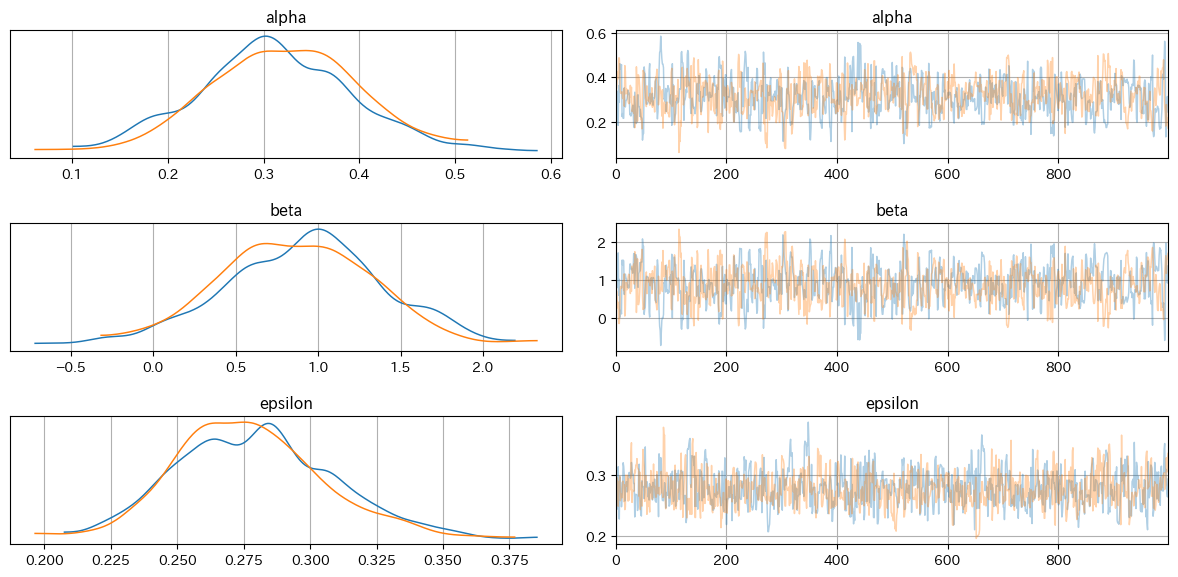

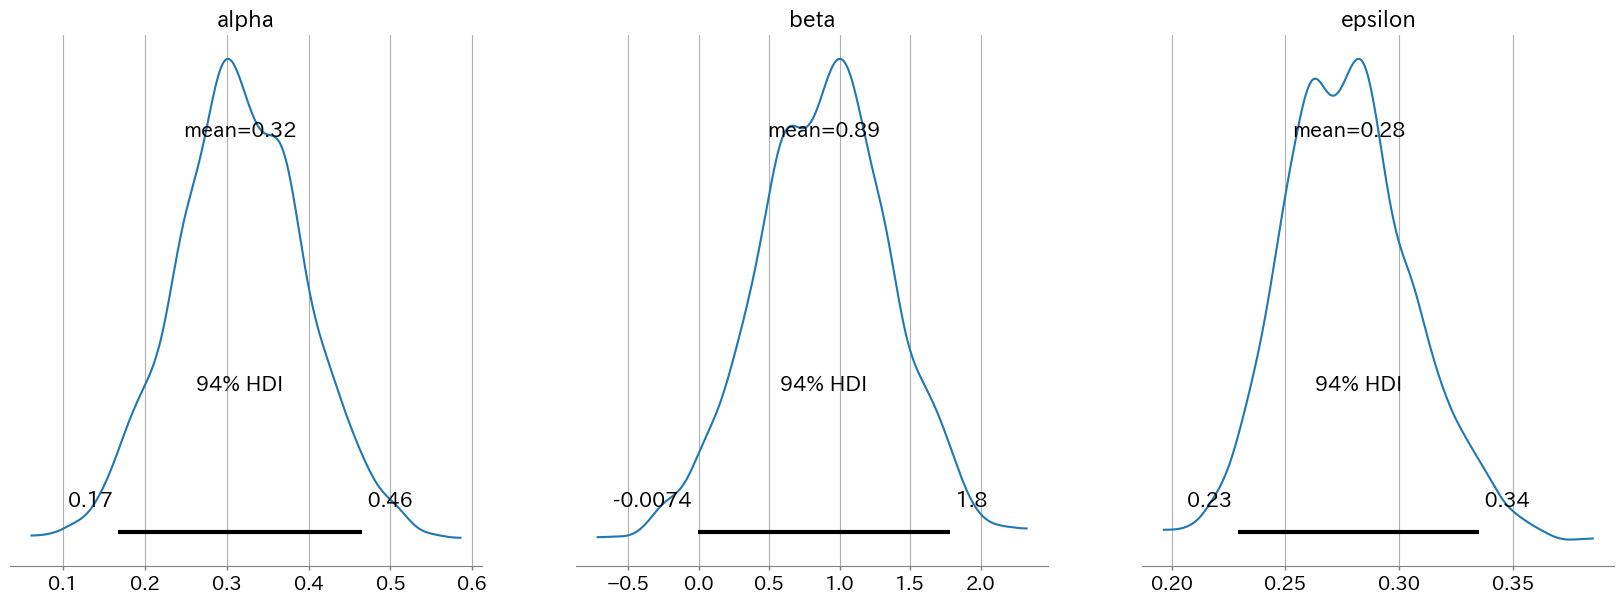

In [24]:
# サンプリングの可視化
az.plot_trace(idata, compact = False, var_names = ["alpha", "beta", "epsilon"])
plt.tight_layout();

az.plot_posterior(idata, var_names = ["alpha", "beta", "epsilon"]);

[4.800 7.100] (2,)
(2000, 1) (2000, 1)


Text(0, 0.5, 'sepal_width')

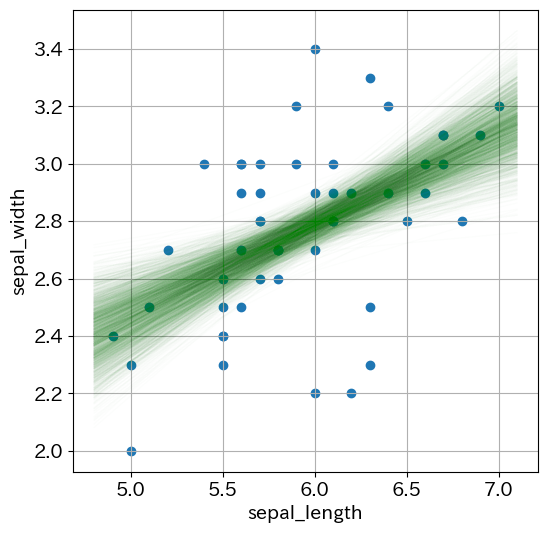

In [27]:
# 散布図と回帰直線の描画

# 入力データとして2点作成
x_values = np.array([X.min()-0.1, X.max()+0.1])
print(x_values, x_values.shape)

# サンプリング結果からパラメータ抽出
alpha_ifr = idata["posterior"]["alpha"].values.reshape(-1, 1)
beta_ifr = idata["posterior"]["beta"].values.reshape(-1, 1)
print(alpha_ifr.shape, beta_ifr.shape)

# 各パラメータの組み合わせで、yの予測値を計算
y_preds = x_values * alpha_ifr + beta_ifr

# 描画
for y_pred in y_preds:
    plt.plot(x_values, y_pred, lw=1, alpha=0.01, c="g") # 回帰直線
plt.scatter(X, Y)# 散布図
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

### 少ないデータでの推論

[40, 7, 1]
[5.500 4.900 6.400] [2.600 2.400 3.200]


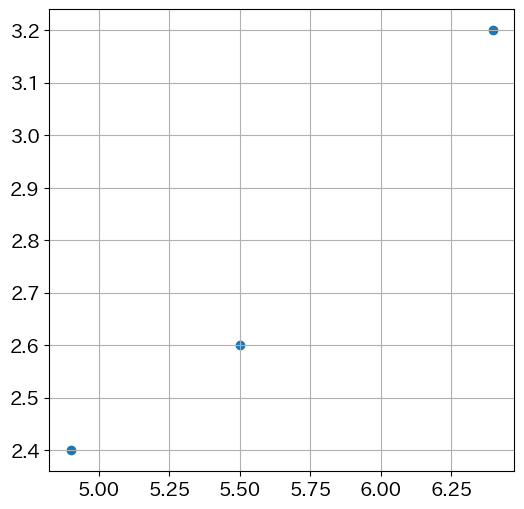

In [32]:
# データ準備
random.seed(42)
indexes = range(len(X))
sample_indexes = random.sample(indexes, 3)
print(sample_indexes)

X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print(X_less.values, Y_less.values)

plt.scatter(X_less, Y_less)

In [38]:
# 確率モデル構造を定義
model2 = pm.Model()

with model2:
    # X, Yの観測値をConstantDataとして定義
    X_obs2 = pm.ConstantData("X_obs2", X_less)
    Y_obs2 = pm.ConstantData("Y_obs2", Y_less)

    # alpha, betaを確率変数として定義(1次関数の傾きと切片)
    alpha2 = pm.Normal("alpha2", mu = 0.0, sigma = 10.0)
    beta2 = pm.Normal("beta2", mu = 0.0, sigma = 10.0)

    # 平均値muを確率変数として定義(Yの期待値的な？)
    mu2 = pm.Deterministic("mu2", alpha2 * X_obs2 + beta2)

    # 誤差の確率変数としてepsilonを定義
    epsilon2 = pm.HalfNormal("epsilon2", sigma = 1.0)

    # 観測値を持つ確率変数としてY_probを定義
    Y_prob2 = pm.Normal("Y_prob2", mu = mu2, sigma = epsilon2, observed = Y_obs2)

    # サンプリング
    idata2 = pm.sample(chains = 2, tune = 1000, draws = 1000, 
                      random_seed = 42,
                      target_accept = 0.995
                      )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha2, beta2, epsilon2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 123 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [40]:
display(az.summary(idata2, var_names = ["alpha2", "beta2", "epsilon2"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha2,0.513,0.419,-0.375,1.332,0.024,0.017,316.000,405.000,1.020
beta2,-0.141,2.351,-5.098,4.414,0.135,0.096,307.000,386.000,1.020
epsilon2,0.425,0.351,0.031,1.107,0.024,0.017,161.000,263.000,1.020


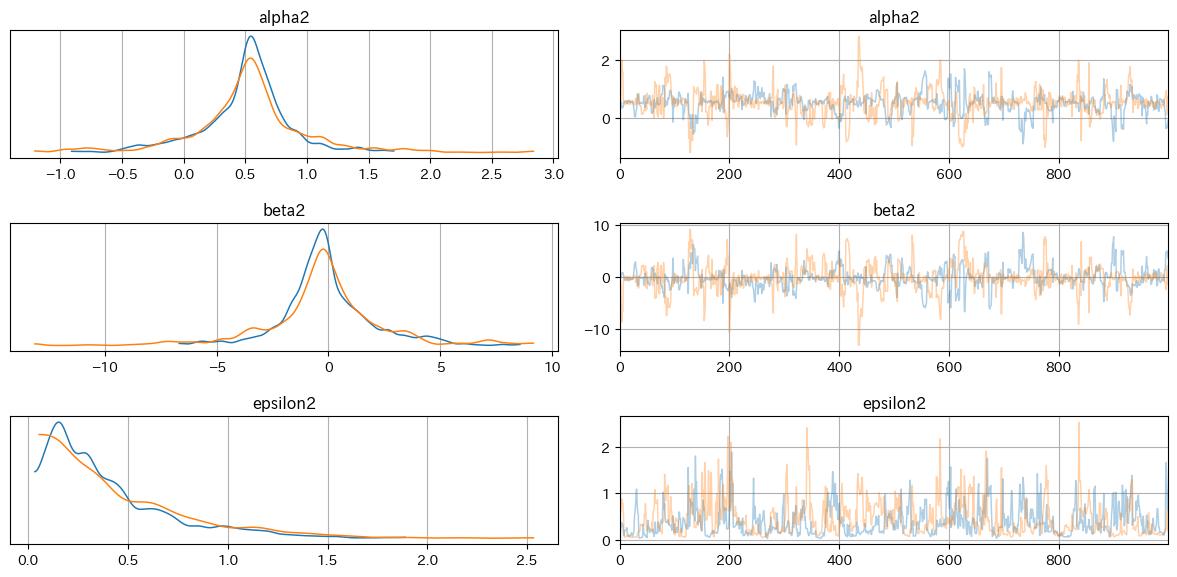

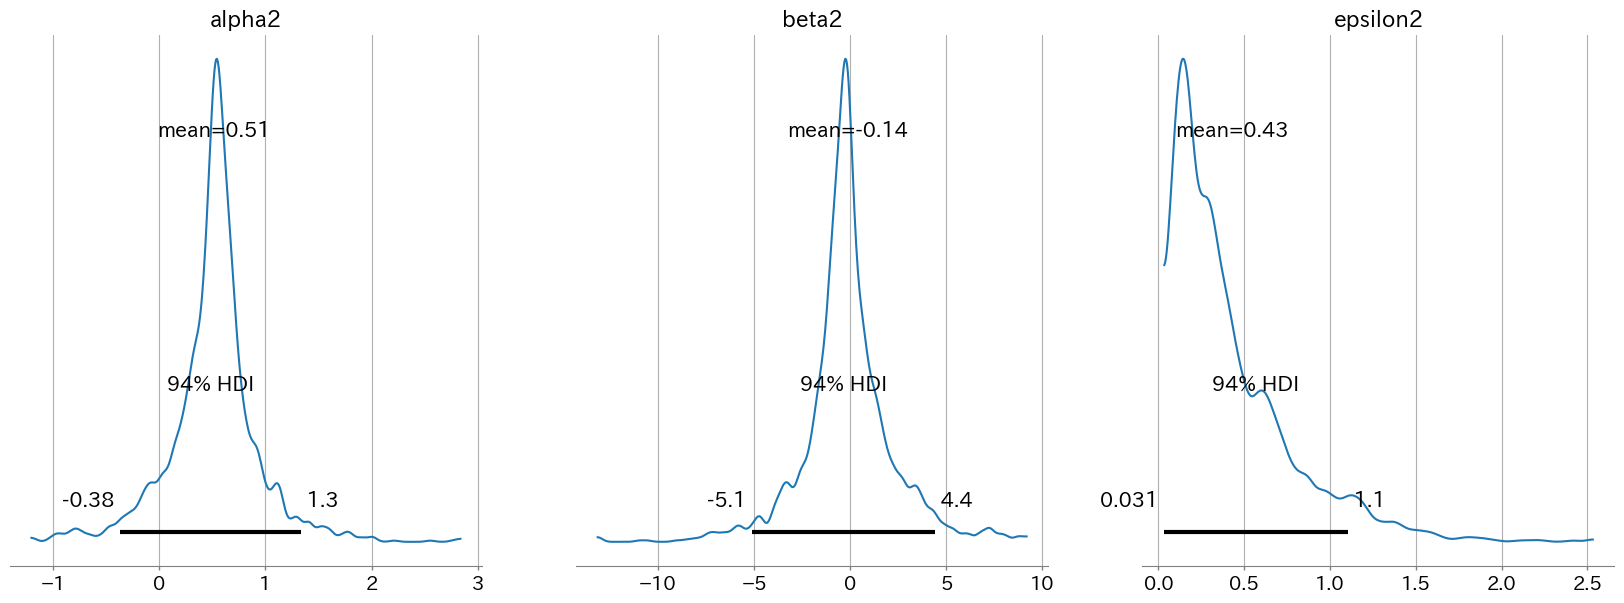

In [41]:
# サンプリングの可視化
az.plot_trace(idata2, compact = False, var_names = ["alpha2", "beta2", "epsilon2"])
plt.tight_layout();

az.plot_posterior(idata2, var_names = ["alpha2", "beta2", "epsilon2"]);

[4.800 6.500] (2,)
(2000, 1) (2000, 1)


Text(0, 0.5, 'sepal_width')

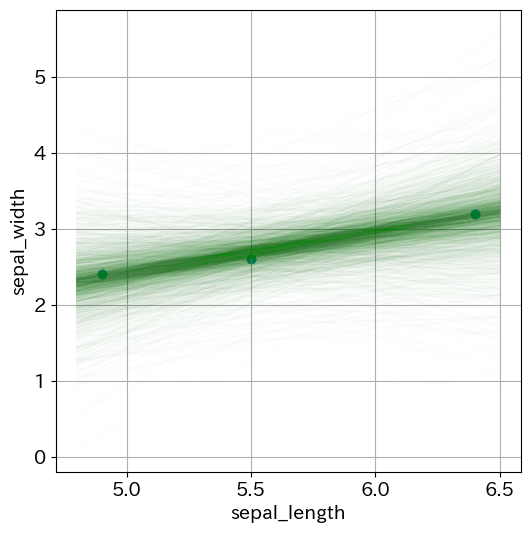

In [42]:
# 散布図と回帰直線の描画
# 入力データとして2点作成
x_values2 = np.array([X_less.min()-0.1, X_less.max()+0.1])
print(x_values2, x_values2.shape)

# サンプリング結果からパラメータ抽出
alpha_ifr2 = idata2["posterior"]["alpha2"].values.reshape(-1, 1)
beta_ifr2 = idata2["posterior"]["beta2"].values.reshape(-1, 1)
print(alpha_ifr2.shape, beta_ifr2.shape)

# 各パラメータの組み合わせで、yの予測値を計算
y_preds2 = x_values2 * alpha_ifr2 + beta_ifr2

# 描画
for y_pred in y_preds2:
    plt.plot(x_values2, y_pred, lw=1, alpha=0.01, c="g") # 回帰直線
plt.scatter(X_less, Y_less)# 散布図
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")